====================================GridWorld Problem================================================

This code is to implement various algorithms on a gridworld MDP problem.
1. Constructing the gridworld environment to generate sample episodes.
2. Using Monte Carlo method with exploring starts and without exploring starts to learn an optimal policy.
3. Using behaviour policy of an equiprobable moves to learn an optimal policy.
4. Use policy iteration to learn an optimal policy for the gridworld with stochastic state permutation

-----------------------------------------------------------------------------------------------------------------
Problem Statement...........................................................

<img src="images/part2.PNG" width="800" height="800" />

# Necessary Libraries

In [1]:
import numpy as np                                                             # package for scientific computing with arrays
import matplotlib.pyplot as plt                                                # library for creating visualizations  
from matplotlib_inline.backend_inline import set_matplotlib_formats            # library to display quality visualization
set_matplotlib_formats('svg', 'pdf')                                           # plots as svg or pdf
import random
from plot import plot_action_value, policy_plot                                # plot function to visulize state-action values and policy

# Set Random Seed

In [2]:
# for reproducibility
np.random.seed(42)
random.seed(42)

# Gridworld MDP Environment

In [3]:
# create the gridworld environment as GridWorldMDP 
class GridworldMDP(object): 

    # initialize the parameters of the environement 
    # gridsize --> size of the grid in (row, col)
    # state_space --> all possible states
    # action_space --> all possible actions in a state                                                                 
    def __init__(self):                                                                         
        self.gridsize = (5, 5)                                                                  
        self.state_space = [(row, col) for row in range(self.gridsize[0]) 
                            for col in range(self.gridsize[1])]
        self.action_space = ['up', 'down', 'left', 'right']

        # effect of action on row and col
        self.action_delta = {'up': (-1, 0),
                             'down': (1,0),
                             'left': (0, -1),
                             'right': (0, 1)
                             }
        
        # special states
        self.blue_state = (0, 1)
        self.green_state = (0, 4)
        self.red_state = (4, 2)
        self.yellow_state = (4, 4)
        self.black_state = [(4, 0), (2, 4)]

    # check if state is terminal
    def isTerminalState(self, state):
        return state in self.black_state
    
    # function to obtain next state and reward for taking an action in the current state
    # needed to generate samples for episodes, it doesn't ptovide the transition probability
    def nextStateReward(self, state, action):
        
        if state == self.blue_state:
            next_state = self.red_state
            reward = 5
            return (next_state, reward)
        
        elif state == self.green_state:
            reward = 2.5
            possible_next_state = [self.yellow_state, self.red_state]
            probs = [0.5, 0.5]
            selected_idx = np.random.choice(len(possible_next_state), p= probs)
            next_state = possible_next_state[selected_idx]
            return (next_state,reward)
        
        else:
            delta = self.action_delta[action]
            next_state = (state[0]+delta[0], state[1]+delta[1])

            # check if next state is within the grid
            if 0 <= next_state[0] < self.gridsize[0] and 0 <= next_state[1] < self.gridsize[1]:
                reward = -0.2
                return (next_state, reward)
            else:
                reward = -0.5
                return(state, reward)
    
    # make gridworld dynamic
    def updateGridWorld(self, probability= 0.1):
        if np.random.random() < probability:
            temp = self.blue_state
            self.blue_state = self.green_state
            self.green_state = temp

    
    # reset gridworld to the normal state
    def reset(self):
        self.blue_state = (0, 1)
        self.green_state = (0, 4)


# Monte Carlo ES (Exploring States) for Optimal Policy

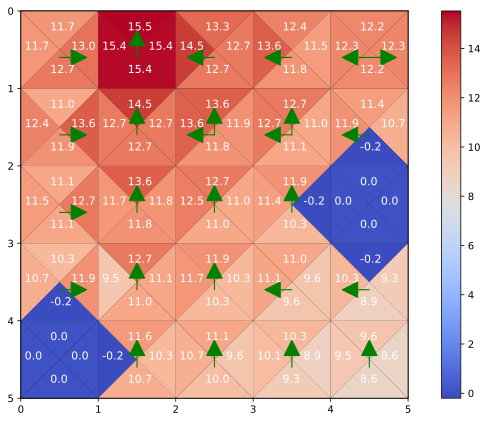

In [4]:
def monteCarloES(mdp, num_episodes, max_episode_length=100):
    # initialization.................................................................
    # placeholder for state-action values
    Q = {}

    # placeholder for the number of times a state-action pair is visited (incremental approach)
    state_action_counts = {}

    for state in mdp.state_space:
        for action in mdp.action_space:
            Q[(state, action)] =  0
            state_action_counts[(state, action)] = 0 

    # discount rate for future returns
    gamma = 0.95

    # equiprobable moves policy: all action have equal probability
    policy = {} 
    for state in mdp.state_space:
        policy[state] = [1/len(mdp.action_space)]*len(mdp.action_space)


    # generate episodes .................................................................................
    for episode in range(num_episodes):

        non_terminal_states = [state for state in mdp.state_space if not mdp.isTerminalState(state)]
        start_state = non_terminal_states[np.random.choice(len(non_terminal_states))]
        start_action =  mdp.action_space[np.random.choice(len(mdp.action_space))]

        # placeholder for the episode
        trajectory = []

        # starting state and action
        state = start_state
        action = start_action
        episode_length = 0

        while True:
            (next_state, reward) = mdp.nextStateReward(state, action)

            trajectory.append(((state, action), reward))

            # update state and follow policy to generate next episode samples
            state = next_state
            action_probs = policy[state]
            action = mdp.action_space[np.random.choice(len(mdp.action_space), p= action_probs)]

            episode_length += 1

            if mdp.isTerminalState(state) or episode_length == max_episode_length:
                break

        # initialize discounted returns              
        G = 0

        # loop through the trajectory backwards
        for t in range(len(trajectory)-1, -1, -1):

            (state, action), reward = trajectory[t]

            G = gamma * G + reward

            # check if it is first visit
            if (state, action) not in [x[0] for x in trajectory[:t]]: 

                # update count
                state_action_counts[(state, action)] += 1

                # update state-action value using incremental approach
                Q[(state, action)] += (G - Q[(state, action)]) /state_action_counts[(state, action)]

                # update policy..........................................
                # placeholder for all action value functions of the state
                s_a_value = []
                for (s, a), value in Q.items():
                    if s == state:
                        s_a_value.append(round(value, 1))
                # all actions that gives maximum Q
                best_action = np.where(np.array(s_a_value)==max(s_a_value))[0]

                # action probabilities
                prob = 1/len(best_action)
                new_prob = []
                for idx, action in enumerate(mdp.action_space):
                    if idx in best_action:
                        new_prob.append(prob)
                    else:
                        new_prob.append(0)

                # update the policy
                policy[state] = new_prob 
            

    return Q, policy


# implement monte carlo ES.........................................
mdp = GridworldMDP()
num_episodes = 60000
Q, policy = monteCarloES(mdp, num_episodes)

# Visualize Q and Policy
# convert policy probabilities to actions
policy_to_action = np.empty(mdp.gridsize, dtype= object)
for state in mdp.state_space:
    policy_to_action[state] = [] 
    
    # update for nonterminal state
    if not mdp.isTerminalState(state):                                            
        action_probs = policy[state]
        for idx, prob in enumerate(action_probs):
            if prob != 0:
                action = mdp.action_space[idx]
                policy_to_action[state].append(action)


# convert Q to grid for easy visualization
action_value_grid = np.zeros((len(mdp.state_space), len(mdp.action_space)))

for i, state in enumerate(mdp.state_space):
    for j, action in enumerate(mdp.action_space): 
        value = Q[(state, action)]
        action_value_grid[(i,j)] = value

# Visualize Q and Policy
plot_action_value(mdp= mdp,
                  action_value_grid= action_value_grid,
                  plot_policy= True,
                  policy= policy_to_action
                  )  

plt.show()

# Monte Carlo without Exploring starts for Optimal Policy

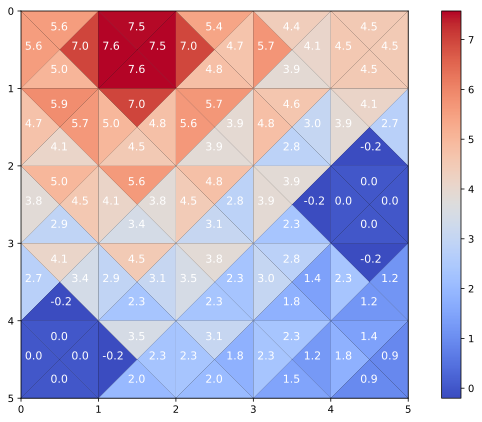

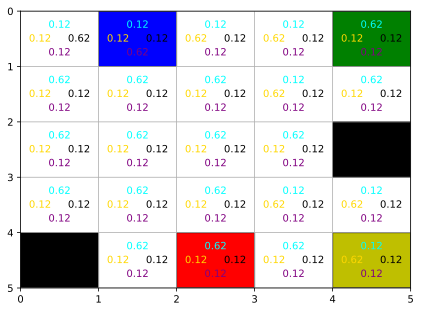

In [5]:
def monteCarloWithoutES(mdp, num_episodes, epsilon):

    # initialization................................
    # placeholder for state-action values
    Q = {}

    # placeholder for the number of times a state-action pair is visited (incremental approach)
    state_action_counts = {}

    for state in mdp.state_space:
        for action in mdp.action_space:
            Q[(state, action)] =  0
            state_action_counts[(state, action)] = 0

    # discount rate for future returns
    gamma = 0.95

    # equiprobable moves policy as starting policy
    policy = {}
    for state in mdp.state_space:
        if mdp.isTerminalState(state):
            policy[state] = [0]*len(mdp.action_space)
        else:
            policy[state] = [1/len(mdp.action_space)]*len(mdp.action_space)


        
    # generate episodes .................................................................................
    for episode in range(num_episodes):
        non_terminal_states = [state for state in mdp.state_space if not mdp.isTerminalState(state)]
        start_state = non_terminal_states[np.random.choice(len(non_terminal_states))]
        # placeholder for episode samples
        trajectory = [] 
        state = start_state

        while True:
            # select action based on policy
            action_probs = policy[state]
            action = mdp.action_space[np.random.choice(len(mdp.action_space), p= action_probs)]

            (next_state, reward) = mdp.nextStateReward(state, action)
            trajectory.append(((state, action), reward))
            state = next_state

            if mdp.isTerminalState(state):
                break 
            

        # initialize discounted returns               
        G = 0       

        # loop the trajectory in a reverse order
        for t in range(len(trajectory)-1,-1,-1):
            (state, action), reward = trajectory[t]

            # update G
            G = gamma * G + reward

            # check if first visit
            if (state, action) not in [x[0] for x in trajectory[:t]]:

                # update count
                state_action_counts[(state, action)] += 1

                # update state-action value function
                Q[(state, action)] += (G - Q[(state, action)]) /state_action_counts[(state, action)]

                # update policy---------------------------------- 
                # placeholder for all action value functions of the state
                s_a_value = []  
                for (s, a), value in Q.items():
                    if s == state:
                        s_a_value.append(round(value, 1))
                
                # obtain action that maximize Q
                A_star =  np.argmax(s_a_value)

                # update policy using epsilon-soft
                new_prob = []
                for idx, action in enumerate(mdp.action_space):
                    if idx == A_star:
                        prob = 1 - epsilon + epsilon/len(mdp.action_space)
                        new_prob.append(prob)
                    else:
                        prob = epsilon/len(mdp.action_space)
                        new_prob.append(prob)           
                policy[state] = new_prob 
        

    return Q, policy 

# implement monte carlo without ES uisng epsilon-soft policy
mdp = GridworldMDP()  

num_episodes = 30000   
epsilon = 0.5   

Q, policy = monteCarloWithoutES(mdp= mdp,
                                num_episodes= num_episodes,
                                epsilon= epsilon)


# rearrange Q into state-action value grid
action_value_grid = np.zeros((len(mdp.state_space), len(mdp.action_space)))
for i, state in enumerate(mdp.state_space):
    for j, action in enumerate(mdp.action_space):
        action_value_grid[(i,j)] = Q[(state, action)]

# visualize Q and Optimal policy
plot_action_value(mdp= mdp,
                  action_value_grid= action_value_grid
                  ) 

# plot action probabilities for each state based on the policy
policy_plot(mdp= mdp,
            policy= policy
            )

plt.show()

# Off-Policy Monte Carlo Control (Importance Sampling)

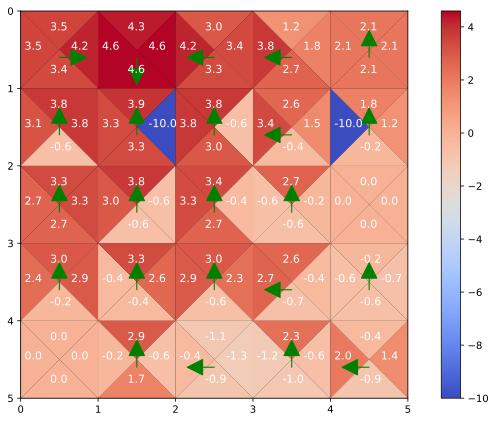

In [6]:
# using behaviour policy of equiprobable moves to learn an optimal policy..................................
def offPolicyMonteCarloControl(mdp, num_episodes):

    # initialization----------------------------------------
    
    # placeholder for state-action pair values
    Q = {}  

    # cummulative sum of weights for every state-action pair
    C = {}  

    # initialize Q values as -10 and C as 0
    for state in mdp.state_space:
        for action in mdp.action_space:
            C[(state, action)] = 0
            if mdp.isTerminalState(state):
                Q[(state, action)] = 0
            else:
                Q[(state, action)] = -10                                                                
                                                           
                                                      
    # discount rate for future rewards
    gamma = 0.95                                                                                    

    # behaviour policy: actions have equal probabilities
    b = {}                                                                                     
    for state in mdp.state_space:
        b[state] = [1/len(mdp.action_space)]*len(mdp.action_space)

    # target policy
    pi = {}

    # generate episode using behaviour policy b
    for episode in range(num_episodes):

        # placeholder for the episode
        trajectory = []

        non_terminal_states = [state for state in mdp.state_space if not mdp.isTerminalState(state)] 
        start_state = non_terminal_states[np.random.choice(len(non_terminal_states))]   

        state = start_state  

        while True:
            action_probs = b[state]
            action = mdp.action_space[np.random.choice(len(mdp.action_space), p= action_probs)] 
            (next_state, reward) = mdp.nextStateReward(state, action)                              
            trajectory.append(((state, action), reward))                                                                                                                
            state = next_state 

            if mdp.isTerminalState(state):
                break               
        
        # initialize discounted returns
        G = 0

        # initialize importance sampling weight
        W = 1

        # iterate through trajectory in reverse order
        for (state, action), reward in reversed(trajectory):

            # update G, C and Q
            G = gamma * G + reward
            C[(state, action)] += W
            Q[(state, action)] += round((W / C[(state, action)]) * (G - Q[(state, action)]), 1)

            # obtain greedy action based on state-action value function
            # place holder for all action values of the state
            s_a_value = []

            for (s,a), v in Q.items():
                if s == state:
                    s_a_value.append(v)

            # greedy action
            best_action = np.argmax(s_a_value)

            # update target policy as the deterministic greedy action
            pi[state] = mdp.action_space[best_action]

            if action != pi[state]:
                break

            # update weight,  pi(At|St) = 1, b(At|St) = 0.25
            W *= 1 / b[state][mdp.action_space.index(action)]   # == W*(1/0.25)

            

    return Q, pi
       

# implement off-policy monte carlo control
mdp = GridworldMDP()
num_episodes = 1000000

Q, pi = offPolicyMonteCarloControl(mdp= mdp, num_episodes= num_episodes)


# convert Q to grid for visualization
action_value_grid = np.zeros((len(mdp.state_space), len(mdp.action_space)))

for i, state in enumerate(mdp.state_space):
    for j, action in enumerate(mdp.action_space):                                     
        action_value_grid[(i,j)] = Q[(state, action)]

# convert policy for visualization
policy = np.empty(mdp.gridsize, dtype= object)                                      
for state in mdp.state_space:
    policy[state] = [] 
    
    if not mdp.isTerminalState(state):
        policy[state].append(pi[state])

# visualize Q and policy pi
plot_action_value(mdp= mdp,
                  action_value_grid= action_value_grid,
                  plot_policy= True,
                  policy= policy
                  )

plt.show()

# Policy Iteration for GridWorld with Stochastic State Permutation

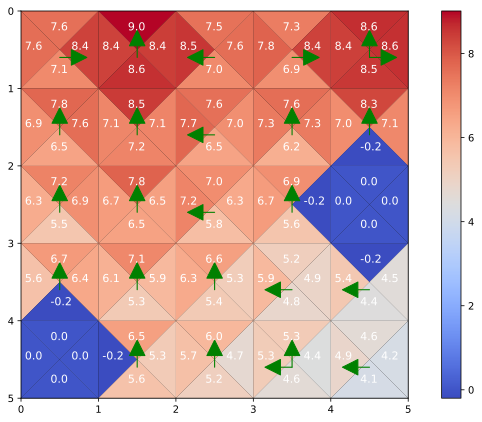

In [7]:
def sarsaPolicyIteration(mdp, epsilon, num_episodes, alpha, max_step = 100):
    # placeholder for state-action value function
    Q = {}

    for state in mdp.state_space:
        for action in mdp.action_space:
            Q[(state, action)] = 0

    # discount rate
    gamma = 0.95

    # help function to choose action using epsilon-greedy
    def policy(state):
        if np.random.random() < epsilon:
            return random.choice(mdp.action_space)
        else:
            action_value = []
            for (s, a), v in Q.items():
                if state == s:
                    action_value.append(v)
            best_action = np.argmax(action_value)
            return mdp.action_space[best_action]
    
    # Training
    for episode in range(num_episodes):
        mdp.reset()

        # choose a start state
        non_terminal_states = [state for state in mdp.state_space if not mdp.isTerminalState(state)]
        start_state = non_terminal_states[np.random.choice(len(non_terminal_states))]
        state = start_state

        # select action based on policy
        action = policy(state)

        # initialize step count per episode
        step = 0

        while True:
            next_state, reward = mdp.nextStateReward(state, action)
            
            next_action = policy(next_state)

            # update Q
            Q[(state, action)] += alpha * (reward + gamma *Q[(next_state, next_action)] - Q[(state, action)])

            # update state and action
            state = next_state
            action = next_action

            # update step
            step += 1

            # permuate the blue and green state based on probability
            mdp.updateGridWorld()

            if mdp.isTerminalState(state) or step == max_step:
                break
    
    return Q


# implementation............................................................
mdp = GridworldMDP()
epsilon = 0.1
num_episodes = 100000
alpha = 0.1

Q = sarsaPolicyIteration(mdp= mdp,
                           epsilon= epsilon,
                           num_episodes= num_episodes,
                           alpha= alpha)

# extract policy (greedy with respect to Q)
policy = np.empty(mdp.gridsize, dtype= object)
for state in mdp.state_space:
    policy[state] = []

    if not mdp.isTerminalState(state):
        action_values = []
        for (s,a), v in Q.items():
            if s == state:
                action_values.append(round(v, 1))
        
        best_action = np.where(np.array(action_values) == max(action_values))[0]

        for idx in best_action:
            action = mdp.action_space[idx]
            policy[state].append(action)

    
# convert Q to grid for easy visualization
action_value_grid = np.zeros((len(mdp.state_space), len(mdp.action_space)))

for i, state in enumerate(mdp.state_space):
    for j, action in enumerate(mdp.action_space): 
        value = Q[(state, action)]
        action_value_grid[(i,j)] = value

# Visualize Q and Policy
plot_action_value(mdp= mdp,
                  action_value_grid= action_value_grid,
                  plot_policy= True,
                  policy= policy
                  )  


plt.show() 